In [1]:
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [4]:
gp = GaussianProcessRegressor(kernel=RBF())

In [5]:
x = np.linspace(0.1, 5, 50)
curves = gp.sample_y(x.reshape((50, 1)), 20)

In [6]:
print(curves.shape)

(50, 20)


In [7]:
F = np.zeros((500, 2))  # 10 epochs x 50 time points x 2 factors
for i in range(10):
    for j in range(2):
        F[(i * 50):(i * 50 + 50), j] = curves[:, (i * 2 + j)]

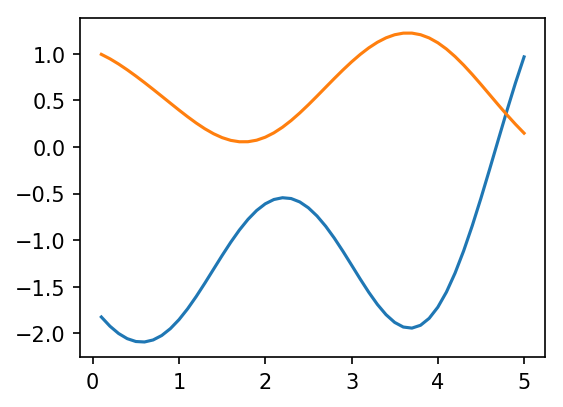

In [8]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(x, F[:50, j])

In [9]:
loading = np.random.normal(0, 1, [2, 6])
Y_true = np.matmul(F, loading)
Y = Y_true + np.random.normal(0, 0.5, [500, 6])

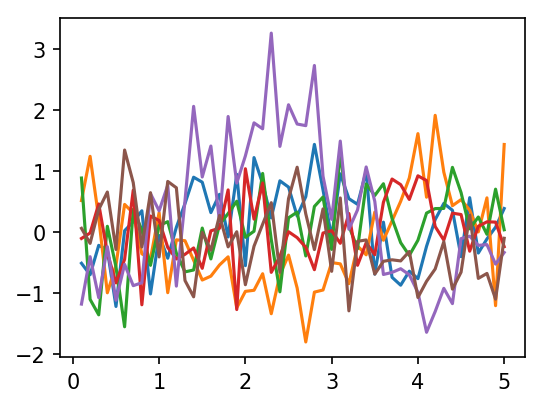

In [10]:
fig = plt.figure(figsize=(4, 3), dpi=150)
i = 2
for j in range(6):
    plt.plot(x, Y[(i * 50):(i * 50 + 50), j])
plt.show()

In [11]:
from sklearn.decomposition import PCA

In [12]:
latent_dim = 2
pca = PCA(n_components=latent_dim)
components = pca.fit_transform(Y)

In [13]:
Y_hat = pca.inverse_transform(components)
mse = np.mean((Y - Y_hat) ** 2)
print(mse)

0.16067768027365426


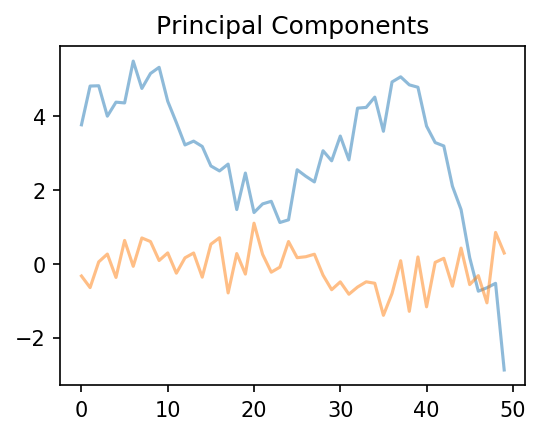

In [14]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(components[:50, j], alpha=0.5)
plt.title('Principal Components')
plt.show()

In [15]:
from scipy.stats import gamma, cauchy, multivariate_normal, norm

In [16]:
def accept_reject(accept_prob):
    u = np.random.uniform(low=0.0, high=1.0, size=1)
    return u < accept_prob

In [17]:
def l_gamma_prior(l, a, b):
    return gamma.pdf(l, a=a, scale=1/b)

In [18]:
def s_half_cauchy_prior(s, scale):
    return 2 * cauchy.pdf(s, loc=0, scale=scale)

In [19]:
def kernel_covariance(x, l, s, noise=1e-6):
    t = x.shape[0]
    cov_sample = np.zeros((t, t))
    for i in range(t):
        for j in range(t):
            cov_sample[i, j] = s ** 2 * np.exp(-(x[i] - x[j]) ** 2 / (2 * l ** 2))
    cov_sample += np.eye(t) * noise
    return cov_sample

In [20]:
def gp_marginal_likelihood(y, x, l, s):
    t = y.shape[0]
    mu = np.repeat(0, t)
    cov = kernel_covariance(x, l, s)
    return multivariate_normal.pdf(y, mu, cov)

In [21]:
def propose_new(current, std):
    value = -1
    while value < 0:
        value = np.random.normal(loc=current, scale=std, size=1)
    return value

In [22]:
def calculate_p_new(l, s, Y, x, prior_params):
    a, b, scale = prior_params
    prior = l_gamma_prior(l, a, b) #* s_half_cauchy_prior(s, scale)
    loglik = 0.0
    for j in range(Y.shape[1]):
        #print(np.log(gp_marginal_likelihood(Y[:, j], x, l, s)))
        loglik += np.log(gp_marginal_likelihood(Y[:, j], x, l, s)) # independent observations
    return np.log(prior) + loglik

In [23]:
def metropolis_update_new(l, s, p, Y, x, prior_params, proposal_params):
    l_new = propose_new(l, proposal_params[0])
    #s_new = propose_new(s, proposal_params[1])
    s_new = 1.0
    
    p_new = calculate_p_new(l_new, s_new, Y, x, prior_params)
    
    if accept_reject(np.exp(p_new - p)):
        return l_new, s_new, p_new
    else:
        return l, s, p

In [24]:
from tqdm import tqdm as tqdm

In [25]:
def metropolis_sample_new(n_iter, Y, x, prior_params=[10, 0.1, 0.5], proposal_params=[0.2, 0.2]):
    l = propose_new(1, proposal_params[0])
    #s = propose_new(1, proposal_params[1])
    s = 1.0
    p = calculate_p_new(l, s, Y, x, prior_params)
    
    l_trace = []
    s_trace = []
    for i in range(n_iter):
        l, s, p = metropolis_update_new(l, s, p, Y, x, prior_params, proposal_params)
        l_trace.append(l)
        s_trace.append(s)
        
    return l_trace, s_trace

In [27]:
from gibbs import *

In [28]:
def sample_regression_posterior(Y, F):
    r = F.shape[1]
    mu_0 = np.repeat(0, r)  # prior mean 0 for regression coefficients
    Sigma_0 = np.diag(np.repeat(1, r))  # prior variance 1
    loading_matrix, Y_variance = blr_mv(Y, F, mu_0, Sigma_0, 2, 1)
    return loading_matrix, Y_variance

In [29]:
def reshape_latent_curves(F, n):
    nt, r = F.shape
    t = int(nt / n)
    F_curves_list = []
    for j in range(r):
        F_curves = np.zeros((t, n))
        for i in range(n):
            F_curves[:, i] = F[(i * t):(i * t + t), j]
        F_curves_list.append(F_curves)
    return F_curves_list

In [30]:
def sample_gp_posterior(F_curves):
    t = F_curves.shape[0]
    x = np.linspace(0.1, t * 0.1, t)
    l_trace, s_trace = metropolis_sample_new(100, F_curves, x)
    return l_trace[-1], s_trace[-1]

In [31]:
def sample_covs(F, n):
    nt, r = F.shape
    t = int(nt / n)
    F_curves_list = reshape_latent_curves(F, n)
    covs = []
    for F_curves in F_curves_list:
        l, s = sample_gp_posterior(F_curves)
        x = np.linspace(0.1, t * 0.1, t)
        covs.append(kernel_covariance(x, l, s))
    return covs

In [32]:
n = 10
nt, r = F.shape
t = int(nt / n)

In [33]:
loading_matrix = np.random.normal(0, 1, [2, 6])
Y_variance = np.random.normal(0, 0.5, 6) ** 2
cov1 = kernel_covariance(x, 1.0, 1.0)  # length scale 1.0 corresponds to 10 time points
cov2 = kernel_covariance(x, 1.0, 1.0)  # variance scale set to 1.0 as well
S1, S2, S3, S4 = build_covariance_blocks([cov1, cov2], loading_matrix, Y_variance)
F0 = np.zeros((n * t, r))
F_covs = []
for i in range(n):
    F0[(i * t):(i * t + t), :], F_cov = sample_conditional_F(Y[(i * t):(i * t + t), :], S1, S2, S3, S4, debug=True)
    F_covs.append(F_cov)

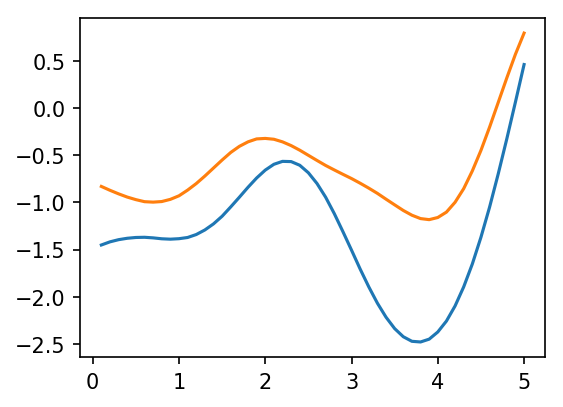

In [40]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(x, F0[:50, j])
plt.show()

In [41]:
F = F0

In [42]:
loading_sample = []
F_sample = []
mse_history = []
    
for i in tqdm(range(20)):
    loading_matrix, Y_variance = sample_regression_posterior(Y, F)
    Y_hat = np.matmul(F, loading_matrix)
    mse = np.mean((Y - Y_hat) ** 2)
    mse_history.append(mse)
    loading_sample.append(loading_matrix)
    covs = sample_covs(F, n)
    S1, S2, S3, S4 = build_covariance_blocks(covs, loading_matrix, Y_variance)
    F = np.zeros((n * t, r))
    for i in range(n):
        F[(i * t):(i * t + t), :] = sample_conditional_F(Y[(i * t):(i * t + t), :], S1, S2, S3, S4)
    F_sample.append(F)


100%|██████████| 20/20 [12:00<00:00, 36.07s/it]

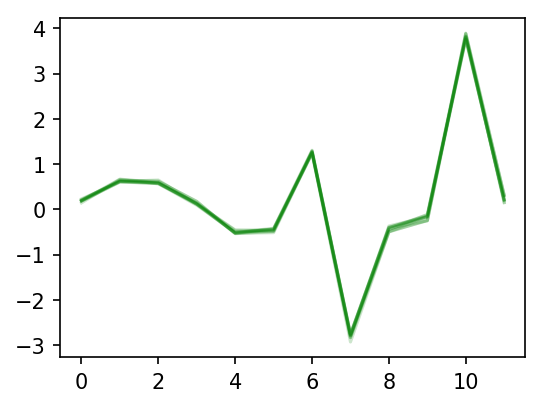

In [48]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(10, 20):
    plt.plot(loading_sample[i].flatten(), alpha=0.2, color='green')
#plt.plot(loading.flatten(), color='black')
plt.show()

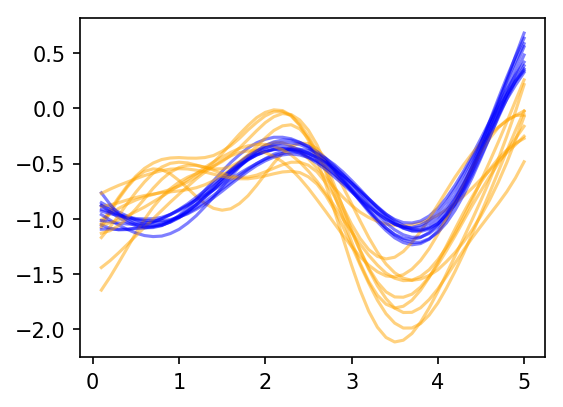

In [47]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(10, 20):
    plt.plot(np.linspace(0.1, t * 0.1, t), F_sample[i][:50, 0], alpha=0.5, color='orange')
    plt.plot(np.linspace(0.1, t * 0.1, t), F_sample[i][:50, 1], alpha=0.5, color='blue')
plt.show()

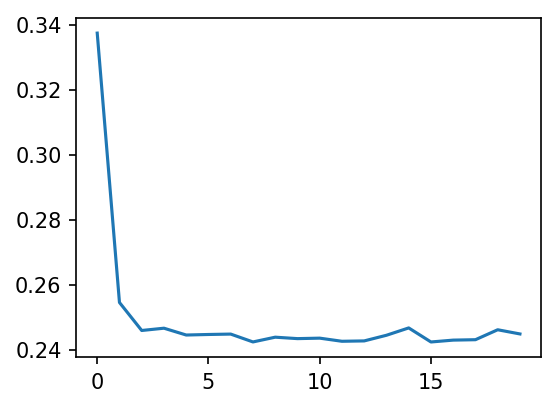

In [46]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(mse_history)
plt.show()